In [2]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

In [3]:
def read_data(path="boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [4]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

In [5]:
def mse(y_true:np.ndarray, y_predicted:np.ndarray):
    N = y_true.shape[0]
    MSE = (np.linalg.norm(y_predicted - y_true) ** 2) / N
    return MSE
    
def r2(y_true:np.ndarray, y_predicted:np.ndarray):
    u = np.linalg.norm(y_predicted - y_true) ** 2
    y_mean = np.linspace(y_true.mean(), y_true.mean(), y_true.shape[0])
    v = np.linalg.norm(y_mean - y_true) ** 2
    r = 1 - u/v
    return r

# NormalLR

In [6]:
class NormalLR:
    def __init__(self):
        self.w = None
        self.b = None
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        N = X.shape[0]
        column_for_b = np.ones((N, 1))
        X = np.column_stack((X, column_for_b))
        X_transp = X.transpose()
        w_b = (np.linalg.inv(X_transp @ X) @ X_transp) @ y
        self.w = w_b[:-1]      
        self.b = w_b[-1]
        
    def predict(self, X:np.ndarray) -> np.ndarray:
        return X @ self.w + self.b

In [14]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [15]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.010560105701003903, R2: 0.9950531134263089


# GradientLR

In [16]:
class GradientLR:
    def __init__(self, alpha:float, iterations=10000, l=0.):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
        self.w = None
        self.b = None
        self.X = None
        self.y = None
        self.N = None
    
    def grad(self, w):
        X = self.X
        y = self.y   
        grad_MSE = (X.transpose() @ (X @ w - y)) / self.N
        grad_Lasso = self.l * np.sign(w)
        grad = grad_MSE + grad_Lasso
        return grad
    
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        self.N = X.shape[0] # количество наблюдений
        dim = X.shape[1] # количество признаков
        column_for_b = np.ones((self.N, 1))
        self.X = np.column_stack((X.copy(), column_for_b))
        self.y = y.copy()
        
        w = np.ones(dim + 1) # начальная точка
        d = -self.grad(w)
        norm_d0 = np.linalg.norm(d) ** 2
        
        for i in range(self.iterations):
            w = w + self.alpha * d
            d = -self.grad(w)
            norm_d = np.linalg.norm(d) ** 2
            if norm_d / norm_d0 < 1e-8:
                break
                
        self.w = w[:-1]  
        self.b = w[-1]
        

    def predict(self, X:np.ndarray):
        return X @ self.w + self.b

In [17]:
def build_plot(X_train, y_train, X_test, y_test):
    xs = np.arange(-0.004, 0.006, 0.00002)
    errors = []
    for x in xs:
        regr = GradientLR(0.1, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.show()

In [29]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

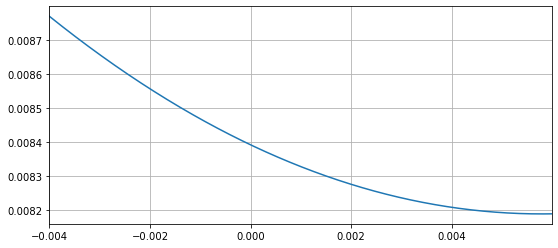

In [30]:
build_plot(X_train, y_train, X_val, y_val)

In [31]:
# с регуляризацией

regr = GradientLR(0.1, iterations=10000, l=0.005)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.010687088025191043, R2: 0.9990225412594419


In [32]:
# без регуляризации

regr = GradientLR(0.1, iterations=10000, l=0)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.010724659533925828, R2: 0.9990191049071332


# Boston.csv

In [33]:
X, y = read_data()
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

# Minimax scale
y_min = np.min(y_train)
y_max = np.max(y_train)
delta_y = y_max - y_min

y_train = (y_train - y_min) / delta_y
y_val = (y_val - y_min) / delta_y


X_min = np.min(X_train, axis=0)
X_max = np.max(X_train, axis=0)
delta_x = X_max - X_min

X_train = (X_train - X_min) / delta_x
X_val = (X_val - X_min) / delta_x

X_test = (X_test - X_min) / delta_x

1. NormalLR

In [34]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test) * delta_y + y_min
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 20491219.288694102, R2: 0.6461335821761031


2. GradientLR (с регуляризацией)

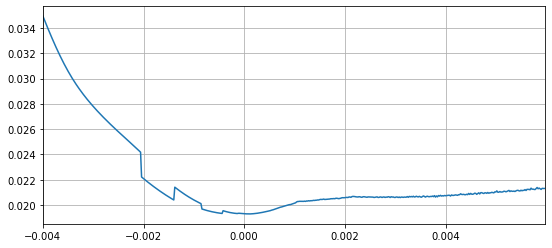

In [35]:
build_plot(X_train, y_train, X_val, y_val)

3. GradientLR (без регуляризации)

In [36]:
regr = GradientLR(0.1, iterations=10000, l=0)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test) * delta_y + y_min
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 22186275.7817863, R2: 0.6168613577774982
